In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn import linear_model
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [145]:
folders = glob.glob("../data/00_gaze_data/sub*")
folders.sort()
subjs = []
for f in folders:
    subjs.append(f[-6:])
print(len(subjs))    
subjs[:3]

condition_index = ['count trash']*20 + ['free viewing']*20
condition_index[:3]

40


['count trash', 'count trash', 'count trash']

In [146]:
list_of_dataframes = []

for i in range(len(subjs)): #use the first 20 subjs 1-20 -- condition1
    read_file_name = '../data/03_fixation_billboards_recall_recognition/'  + subjs[i] +'_fixations_billboards_recall_recognition.csv'
    df = pd.read_csv(read_file_name, index_col = 0)
    df['subject'] = subjs[i]
    df["condition"] = condition_index[i]
    list_of_dataframes.append(df)
    
large_df = pd.concat(list_of_dataframes)

#add in the binary fix feature
large_df['fix_binarized'] = large_df['fix_bill']
large_df.loc[large_df['fix_binarized'] > 1, 'fix_binarized'] = 1

# factorize
#large_df['billboard_image_at_position_text'] = large_df['billboard_image_at_position_text'].factorize()[0]
#large_df['condition'] = large_df['condition'].factorize()[0]

print( 1- (large_df["recall"].sum()/len(large_df)))


large_df['recall'] = large_df['recall'].replace(0,'norecall')
large_df['recall'] = large_df['recall'].replace(1,'recall')


#large_df["recall"] = large_df[large_df["recall"] ==0]

target = large_df["recall"]


data = large_df.drop(['recall', 'recognition', 'subject'], axis=1)
data.head()

from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)
categorical_columns

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
categorical_encoded_data = encoder.fit_transform(data[categorical_columns])
#plt.imshow(categorical_encoded_data[:40,:])
data_cat = pd.DataFrame(categorical_encoded_data)
data_cat.head()

data = data.drop(['billboard_image_at_position_text', 'condition','fix_binarized', 'sum_fa'], axis=1)

data.head()

0.765


,position_index,fix_bill
0,1,2.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


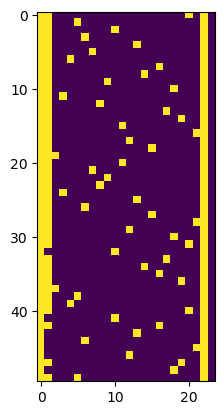

In [147]:
data_joined = np.hstack((data.values, data_cat.values))
data = data_joined
plt.imshow(data[:50,:], vmin = 0, vmax = 1)


In [148]:
target.head()

0    norecall
1    norecall
2    norecall
3    norecall
4    norecall
Name: recall, dtype: object

The mean cross-validation accuracy is: 0.500 ± 0.000
              precision    recall  f1-score   support

    norecall       0.76      0.48      0.59       612
      recall       0.23      0.52      0.32       188

    accuracy                           0.49       800
   macro avg       0.50      0.50      0.46       800
weighted avg       0.64      0.49      0.53       800



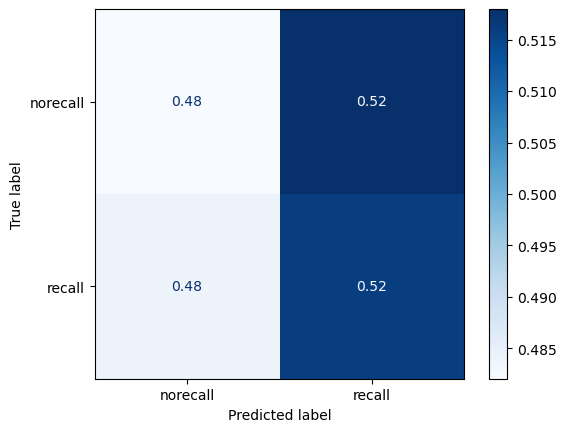

In [149]:
from sklearn.dummy import DummyClassifier
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score


clf_dummy = DummyClassifier(random_state=42, strategy='uniform')  #can comment out the strategy...
#establishing random_state for reproducibility
clf_dummy.fit(data, target)
y_pred = clf_dummy.predict(data)
#plot_confusion_matrix(estimator=clf_dummy, X=data, y_true=target,
#                      normalize='true', cmap='Blues')

disp2 = ConfusionMatrixDisplay.from_estimator(  clf_dummy, data, target, cmap = 'Blues', normalize = 'true')


cv_results = cross_validate(clf_dummy, data, target, cv=5, scoring="roc_auc")
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

from sklearn.metrics import classification_report
print(classification_report(target, y_pred, target_names=clf_dummy.classes_))

In [150]:

cv_results = cross_validate(clf_dummy, data, target, cv=5, scoring="f1_weighted")
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

The mean cross-validation accuracy is: 0.487 ± 0.027


The mean cross-validation accuracy is: 0.728 ± 0.044
              precision    recall  f1-score   support

    norecall       0.89      0.58      0.71       612
      recall       0.36      0.77      0.49       188

    accuracy                           0.63       800
   macro avg       0.63      0.68      0.60       800
weighted avg       0.77      0.63      0.66       800



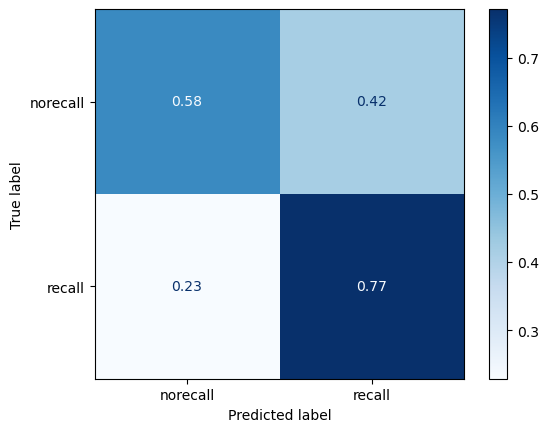

In [151]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics.ConfusionMatrixDisplay import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

clf_3 = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)


cv_results = cross_validate(clf_3, data, target, cv=5, scoring="roc_auc")
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")



clf_3.fit(data, target)

y_pred = clf_3.predict(data)

#cm = confusion_matrix(target, predictions, labels=clf_3.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf_3.classes_)

#disp.plot(cmap = 'Blues');
#plt.show();

disp2 = ConfusionMatrixDisplay.from_estimator(  clf_3, data, target, cmap = 'Blues', normalize='true')
#disp2.plot(cmap = 'Blues')
#plt.show()
#plot_confusion_matrix(estimator=clf_3, X=data, y_true=target,
#                      normalize='true', cmap='Blues')

print(classification_report(target, y_pred, target_names=clf_3.classes_))

In [152]:
cv_results = cross_validate(clf_3, data, target, cv=5, scoring="f1_weighted")
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

The mean cross-validation accuracy is: 0.580 ± 0.098


### remove fixation to find out how much added value

In [84]:
data = data.drop(['fix_bill'], axis=1)
data.head()

,position_index
0,1
1,2
2,3
3,4
4,5


In [85]:
data_cat

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


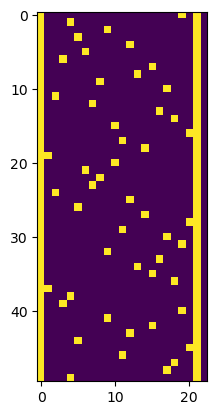

In [86]:
data_joined = np.hstack((data.values, data_cat.values))
data = data_joined
plt.imshow(data[:50,:], vmin = 0, vmax = 1)


The mean cross-validation accuracy is: 0.708 ± 0.064
              precision    recall  f1-score   support

    norecall       0.89      0.58      0.71       612
      recall       0.36      0.77      0.49       188

    accuracy                           0.63       800
   macro avg       0.63      0.68      0.60       800
weighted avg       0.77      0.63      0.66       800



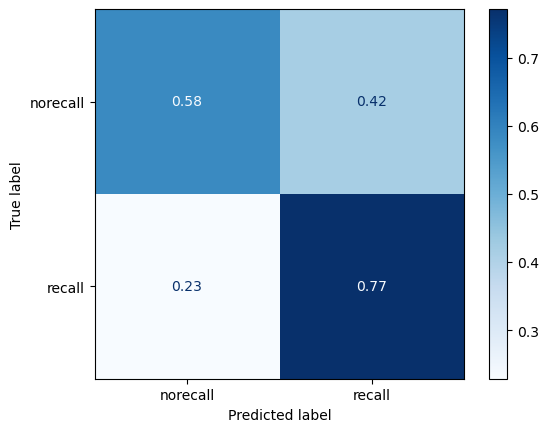

In [89]:

clf_3 = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)


cv_results = cross_validate(clf_3, data, target, cv=5, scoring="roc_auc")
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")



clf_3.fit(data, target)

#plot_confusion_matrix(estimator=clf_3, X=data, y_true=target,
#                      normalize='true', cmap='Blues')


disp = ConfusionMatrixDisplay.from_estimator(  clf_3, data, target, cmap = 'Blues', normalize='true')

print(classification_report(target, y_pred, target_names=clf_3.classes_))

In [91]:
data

array([[ 1.,  0.,  0., ...,  0.,  1.,  0.],
       [ 2.,  0.,  0., ...,  0.,  1.,  0.],
       [ 3.,  0.,  0., ...,  0.,  1.,  0.],
       ...,
       [18.,  0.,  0., ...,  0.,  0.,  1.],
       [19.,  0.,  0., ...,  0.,  0.,  1.],
       [20.,  0.,  0., ...,  0.,  0.,  1.]])

### fix only

In [106]:
data.head()

,position_index,fix_bill
0,1,2.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


In [107]:
data = data.drop(['position_index'], axis=1)
data.head()

,fix_bill
0,2.0
1,1.0
2,1.0
3,1.0
4,1.0


In [112]:
dataX[:5]

array([2., 1., 1., 1., 1.])

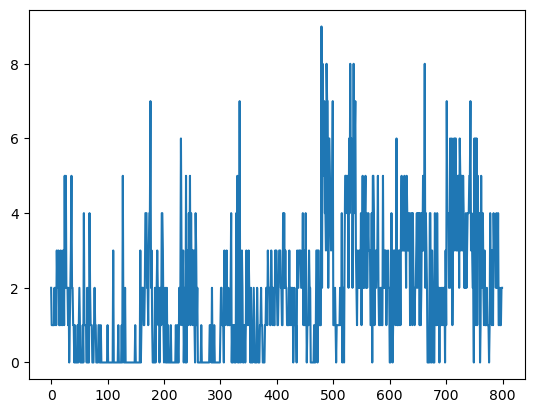

In [115]:
data_joined = data['fix_bill'].values
dataX = data_joined
plt.plot(dataX[:])#, vmin = 0, vmax = 1)


The mean cross-validation accuracy is: 0.646 ± 0.089
              precision    recall  f1-score   support

    norecall       0.89      0.58      0.71       612
      recall       0.36      0.77      0.49       188

    accuracy                           0.63       800
   macro avg       0.63      0.68      0.60       800
weighted avg       0.77      0.63      0.66       800



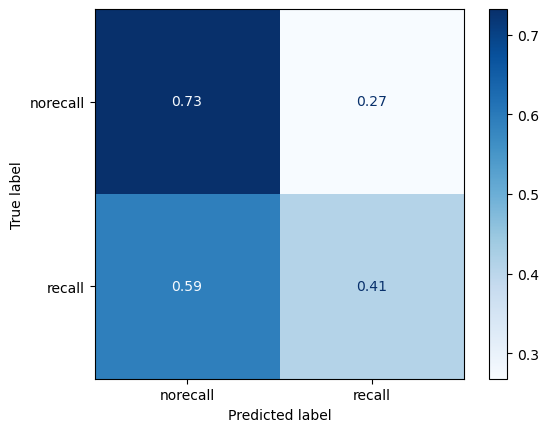

In [116]:

clf_3 = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)


cv_results = cross_validate(clf_3, data, target, cv=5, scoring="roc_auc")
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")



clf_3.fit(data, target)

#plot_confusion_matrix(estimator=clf_3, X=data, y_true=target,
#                      normalize='true', cmap='Blues')

disp = ConfusionMatrixDisplay.from_estimator(  clf_3, data, target, cmap = 'Blues', normalize='true')

print(classification_report(target, y_pred, target_names=clf_3.classes_))

### image only

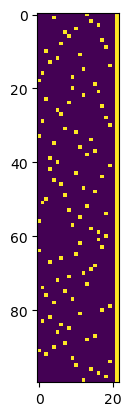

In [120]:

data_joined = data_cat.values
data = data_joined
plt.imshow(data[700:,:], vmin = 0, vmax = 1)


The mean cross-validation accuracy is: 0.662 ± 0.099
              precision    recall  f1-score   support

    norecall       0.89      0.58      0.71       612
      recall       0.36      0.77      0.49       188

    accuracy                           0.63       800
   macro avg       0.63      0.68      0.60       800
weighted avg       0.77      0.63      0.66       800



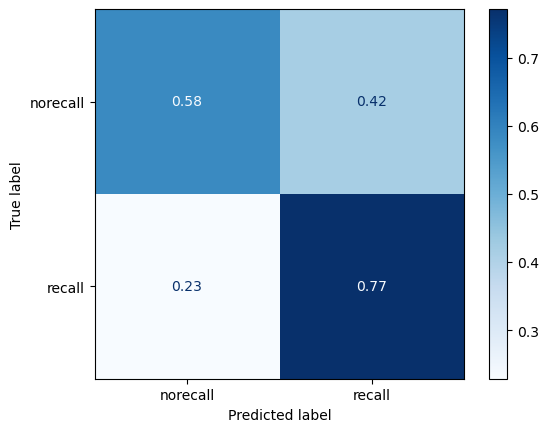

In [122]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate

clf_3 = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)


cv_results = cross_validate(clf_3, data, target, cv=5, scoring="roc_auc")
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")



clf_3.fit(data, target)

#plot_confusion_matrix(estimator=clf_3, X=data, y_true=target,
#                      normalize='true', cmap='Blues')

disp = ConfusionMatrixDisplay.from_estimator(  clf_3, data, target, cmap = 'Blues', normalize='true')

print(classification_report(target, y_pred, target_names=clf_3.classes_))